# HD 140283

In [1]:
import lightkurve as lk
from scipy.ndimage import binary_dilation
import numpy as np
import matplotlib.pyplot as plt

Let's start by looking at the SPOC light curve at 20-second cadence.

In [2]:
target = 'HD 140283'

lc_search = lk.search_lightcurve(target)

lc_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,SPOC,20,290565106,0.0
1,TESS Sector 51,2022,SPOC,120,290565106,0.0
2,TESS Sector 51,2022,TESS-SPOC,600,290565106,0.0
3,TESS Sector 51,2022,QLP,600,290565106,0.0


In [3]:
spoc_lc = lc_search[0].download()

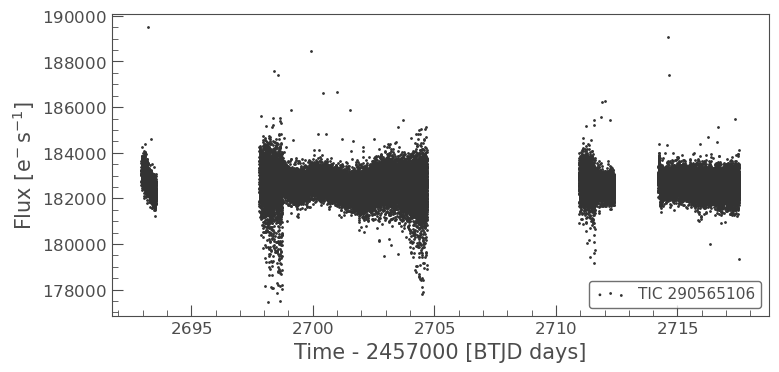

In [4]:
spoc_lc.scatter();

There are significant gaps that are due to scattered light from the Earth and Moon. The SPOC light curve can be overly conservative in removing sections, though, so we can perhaps recover more of the light curve by making our own.

There also seem to be segments with substantial scatter, so we would also like to improve the quality of the light curve.

Let's now download the target pixel file at 20-second cadence.

In [5]:
tpf_search = lk.search_targetpixelfile(target)

tpf_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,SPOC,20,290565106,0.0
1,TESS Sector 51,2022,SPOC,120,290565106,0.0
2,TESS Sector 51,2022,TESS-SPOC,600,290565106,0.0


In [6]:
tpf = tpf_search[0].download()

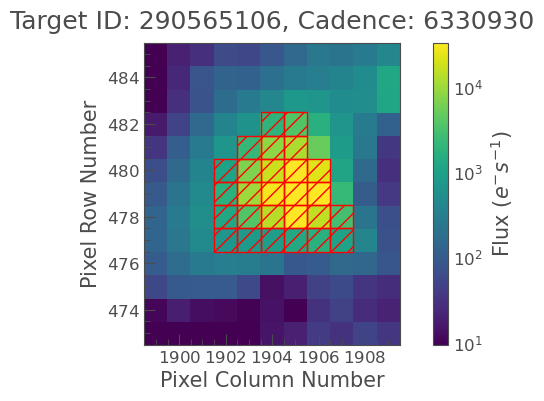

In [7]:
tpf.plot(scale='log',aperture_mask=tpf.pipeline_mask);

It looks like the aperture mask used by the pipeline might be a little small. Let's make our own using the `create_threshold_mask()` method of the target pixel file, with the default threshold of 3 times the standard deviation about the overall median. We will then dilate this mask by an extra pixel to get our final mask.

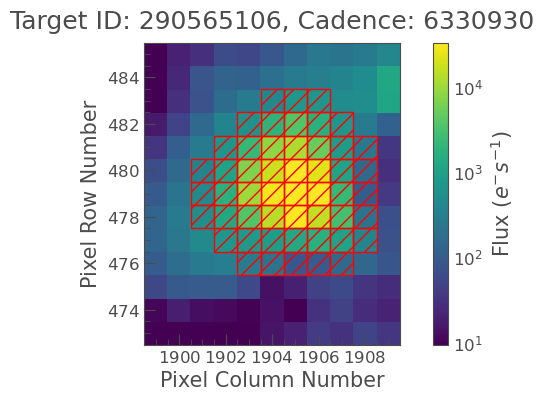

In [8]:
mask = tpf.create_threshold_mask()
mask = binary_dilation(mask,iterations=1)

tpf.plot(scale='log',aperture_mask=mask);

Let's now create a light curve using this mask.

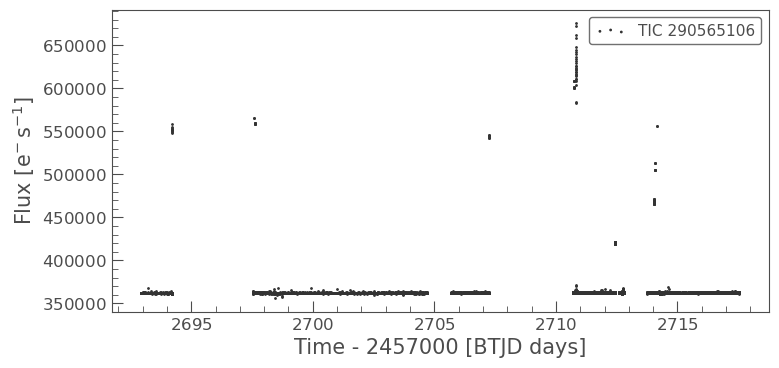

In [9]:
lc = tpf.to_lightcurve(aperture_mask = mask)

lc.scatter();

Ok, there are clearly some outliers here. We should take a look at the quality flags of the data because we probably shouldn't be including some of these cadences.

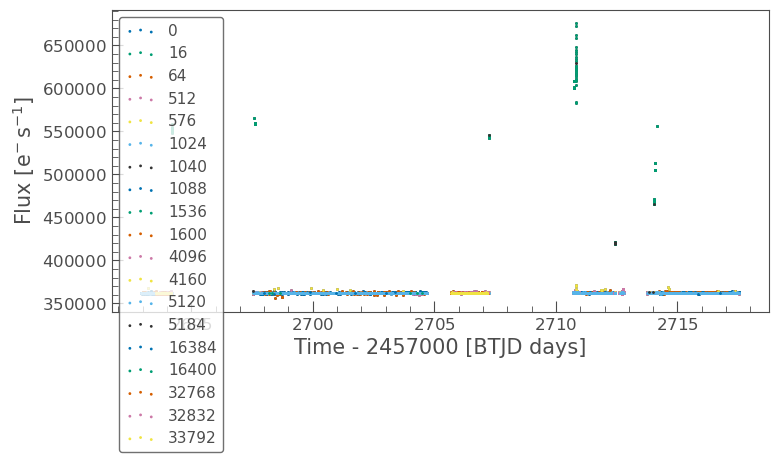

In [10]:
ax = lc.scatter(label='');
for flag in np.unique(lc.quality):
    m = lc.quality == flag
    lc[m].scatter(ax=ax, label=flag);

In [11]:
lk.TessQualityFlags.decode(16)

['Argabrightening']

It looks like the biggest outliers have the quality flag of 16. These are classified as "argabrightening events". Let's make a mask to ignore these cadences.

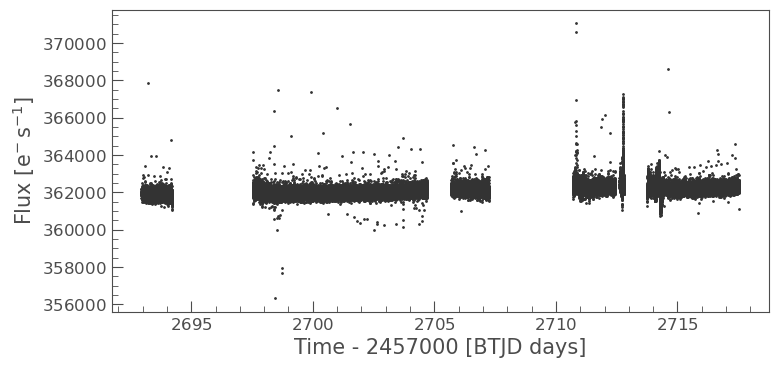

In [12]:
cadence_mask = ((lc.quality & 16) == 0)
ax = lc[cadence_mask].scatter(label='');

Better, but we there are still more outliers we could try remove. Let's look at the quality flags again.

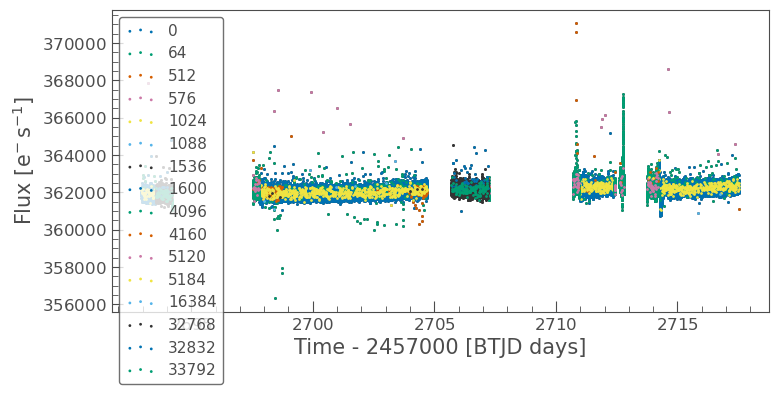

In [13]:
ax = lc[cadence_mask].scatter(label='');
for flag in np.unique(lc[cadence_mask].quality):
    m = lc.quality == flag
    lc[m].scatter(ax=ax, label=flag);

In [14]:
lk.TessQualityFlags.decode(64)

['Cosmic ray in optimal aperture']

It looks like removing cadences with a quality flag of 64 - cosmic ray in optimal aperture pixel - is also a good idea.

In [15]:
cadence_mask = ((lc.quality & 16) == 0) & ((lc.quality & 64) == 0)

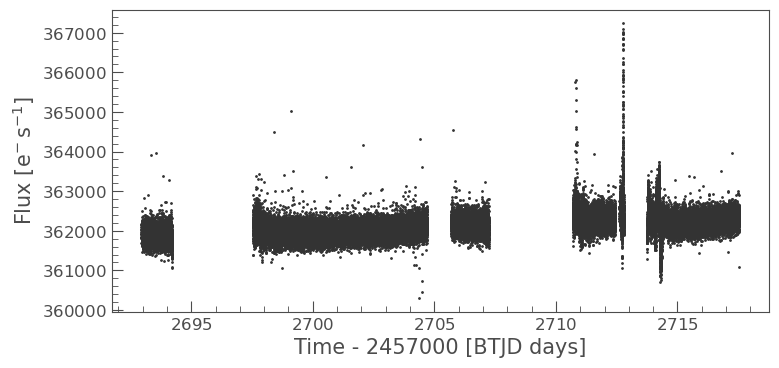

In [16]:
ax = lc[cadence_mask].scatter(label='');

Looking better. Let's try and improve the rest of the light curve using linear regression as implemented in the `RegressionCorrector` class of `lightkurve`.

We will build our regressors from the pixels in the target pixel file that we do not use in making the light curve.

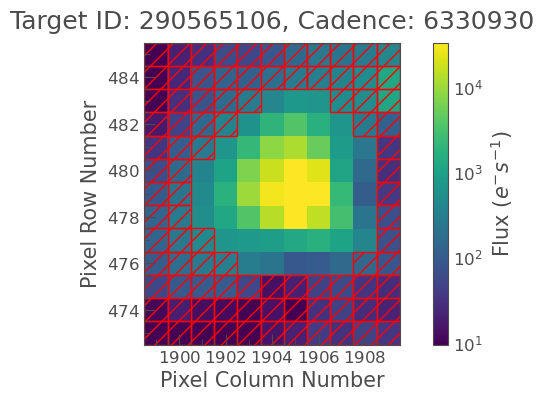

In [17]:
# Indentify NaN pixels
nanpixels = np.isnan(np.nanmean(tpf.flux,axis=0))

# Pixels that are neither in aperture mask or nan
outpixels = ~nanpixels & ~mask

tpf.plot(scale='log',aperture_mask=outpixels);

In [18]:
# Make regressors from outer pixels
regressors = tpf.flux[:,outpixels]

# Identify time steps where flux or flux error is NaN
nantimes = np.isnan(lc.flux_err) | np.isnan(lc.flux) | (np.sum(np.isnan(tpf.flux[:,~nanpixels]),axis=1) > 0)

# Also filter out bad cadences
nantimes = nantimes | ~cadence_mask

# Only include time steps where flux error is ~Nan in regressors
regressors = regressors[~nantimes,:]

# Make design matrix from our regressors, taking 5 principal components, adding a constant
dm = lk.DesignMatrix(regressors, name = 'regressors').pca(5).append_constant()

# Make corrector object
corrector = lk.RegressionCorrector(lc[~nantimes])

# Correct light curve
corrected_lc = corrector.correct(dm)

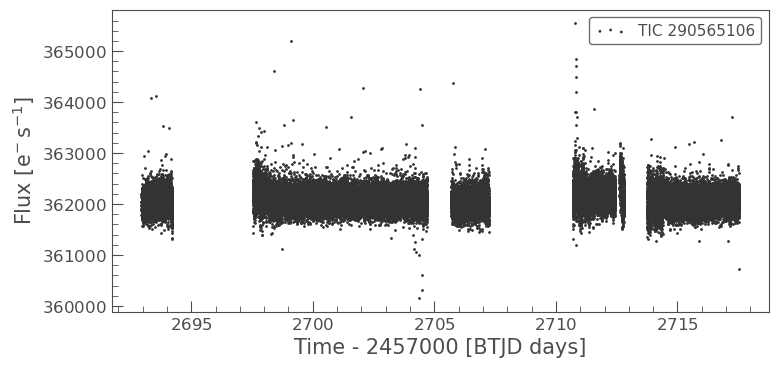

In [19]:
corrected_lc.scatter();

Even better - though still some outliers. Let's check the diagnostic graphs.

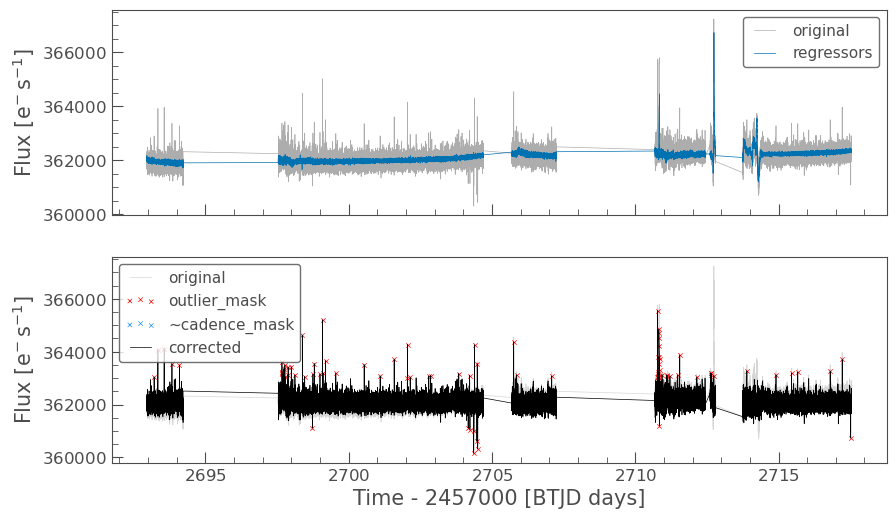

In [20]:
corrector.diagnose();

And look again at the quality flags.

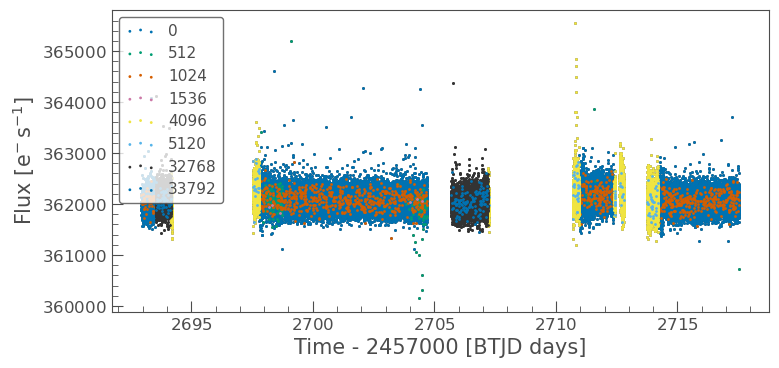

In [21]:
ax = corrected_lc.scatter(label='');
for flag in np.unique(corrected_lc.quality):
    m = corrected_lc.quality == flag
    corrected_lc[m].scatter(ax=ax, label=flag);

In [22]:
lk.TessQualityFlags.decode(4096)

['Straylight2']

Maybe we also ought to remove the cadences with the 'Straylight2' quality flag set.

In [23]:
m = (corrected_lc.quality & 4096) == 0
corrected_lc = corrected_lc[m]

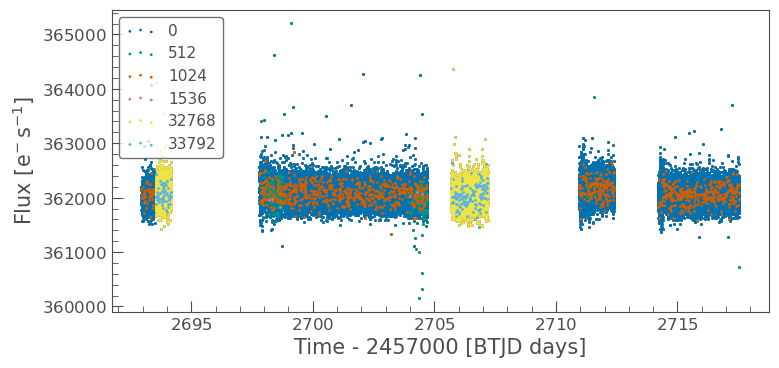

In [24]:
ax = corrected_lc.scatter(label='');
for flag in np.unique(corrected_lc.quality):
    m = corrected_lc.quality == flag
    corrected_lc[m].scatter(ax=ax, label=flag);

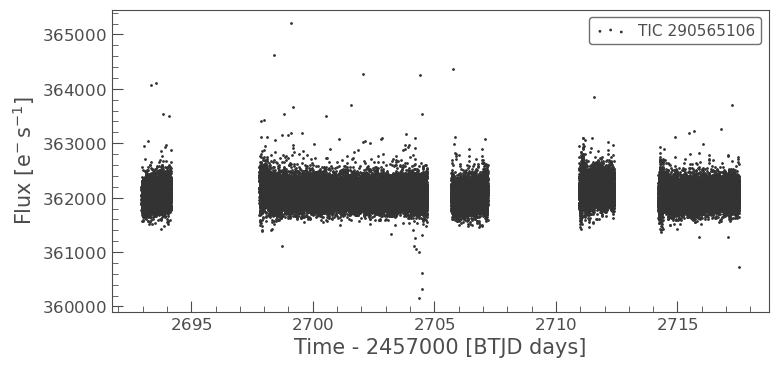

In [25]:
corrected_lc.scatter();

Now lets remove any long term trends in case they are an issue.

In [26]:
flat_lc,trend_lc = corrected_lc.flatten(window_length=5001, return_trend = True, break_tolerance=50)

Check the trend line isn't affected a short timescale.

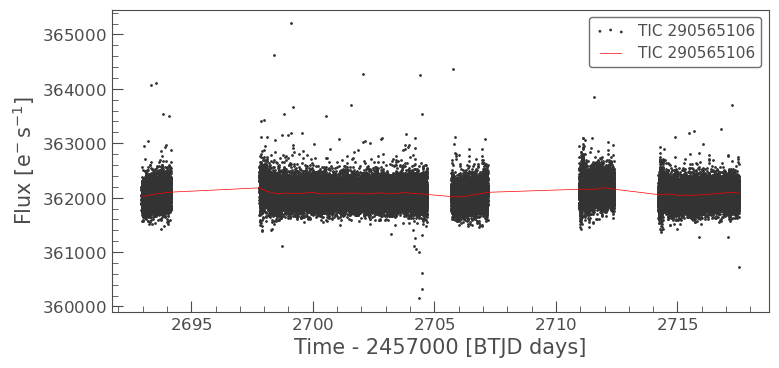

In [27]:
ax = corrected_lc.scatter()
trend_lc.plot(ax=ax,c='r');

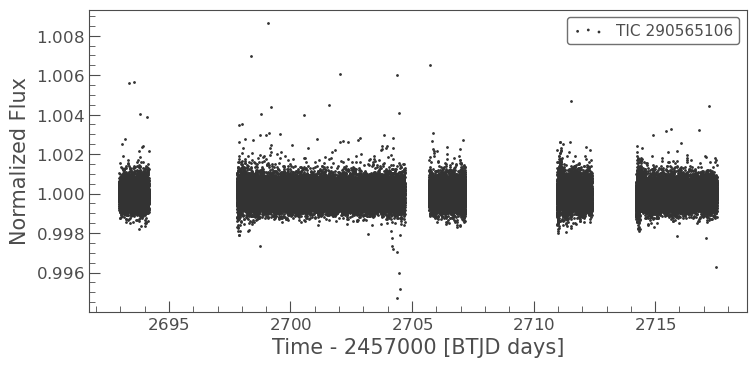

In [28]:
flat_lc.scatter();

Output the corrected light curves, both unflattened and flattened to disk.

In [29]:
corrected_lc.to_csv(path_or_buf='lightcurves/HD140283_20s_S51_SYDSAP_corr.csv')
corrected_lc.to_fits('lightcurves/HD140283_20s_S51_SYDSAP_corr.fits')

In [30]:
flat_lc.to_csv(path_or_buf='lightcurves/HD140283_20s_S51_SYDSAP_corr_flat.csv')
flat_lc.to_fits('lightcurves/HD140283_20s_S51_SYDSAP_corr_flat.fits')

Compare with the orignal light curve:

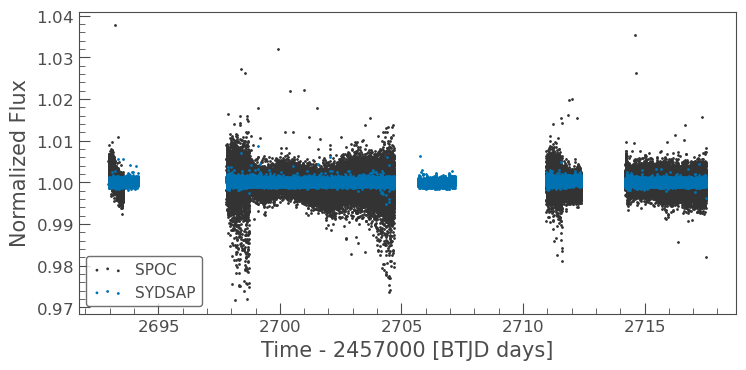

In [31]:
ax = spoc_lc.normalize().scatter(label='SPOC')
corrected_lc.normalize().scatter(ax=ax,label='SYDSAP');

Our new light curve has significantly less scatter in it, which should improve our chances of finding an asteroseismic signal. Additionally we have managed to include some segments of data that were excluded from the SPOC light curve.